In [1]:
!hostname

gnode001.cluster


In [2]:
!nvidia-smi

Tue Jun 20 10:55:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   32C    P0    37W / 250W |      0MiB / 40960MiB |      3%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1500, 400) (1500, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 2.43 s, sys: 18 ms, total: 2.45 s
Wall time: 2.57 s


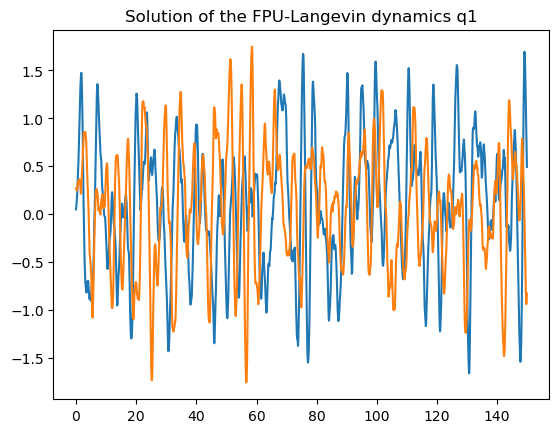

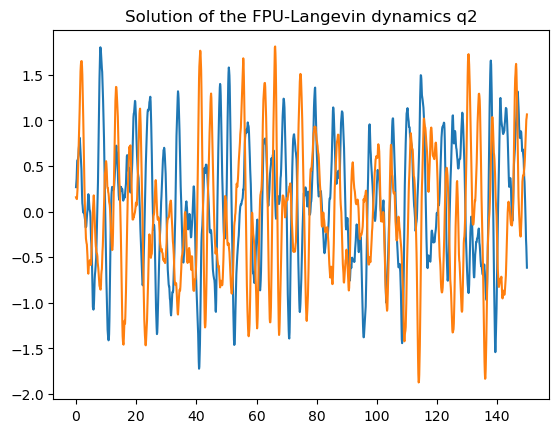

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma = 1                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
rho = 0.10                            # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=rho*q1[1,:]+np.sqrt(1-rho**2)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/4)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)



plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q1")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q2")

# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

# 1. 1 input

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


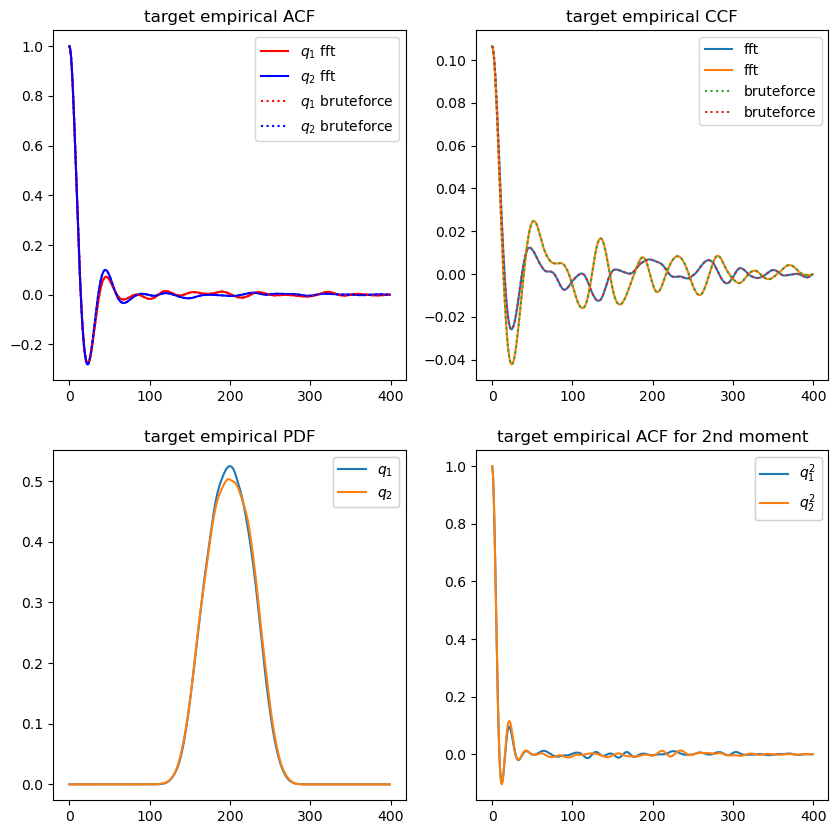

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', r'$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

## 1.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [11]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
### coefficients of loss functions
c1 = 1               # coefficient of CCF
c2 = 1              # coefficient of PDF
c3 = 1               # coefficient of ACF of second moment

In [13]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.001 and pdf<=0.001 and acf_sec_moment<=0.001:
            break

if ccf > 0.001 or pdf >0.001 or acf_sec_moment>0.001:
    print ('Training failed')

print('Training finished')
print(step)

[0]-th step loss: 0.2573, 0.2565, ccf: 0.00650, pdf: 0.24749, acf: 0.00255
[50]-th step loss: 0.5144, 0.5152, ccf: 0.00459, pdf: 0.24698, acf: 0.00077
[100]-th step loss: 0.5822, 0.5825, ccf: 0.00246, pdf: 0.24679, acf: 0.00060
[150]-th step loss: 0.6819, 0.6984, ccf: 0.00223, pdf: 0.24657, acf: 0.00053
[200]-th step loss: 0.7094, 0.7198, ccf: 0.00231, pdf: 0.24635, acf: 0.00045
[250]-th step loss: 0.6899, 0.7073, ccf: 0.00244, pdf: 0.24627, acf: 0.00035
[300]-th step loss: 0.7104, 0.7109, ccf: 0.00256, pdf: 0.24631, acf: 0.00029
[350]-th step loss: 0.7169, 0.7210, ccf: 0.00261, pdf: 0.24632, acf: 0.00025
[400]-th step loss: 0.6773, 0.6724, ccf: 0.00289, pdf: 0.24631, acf: 0.00015
[450]-th step loss: 0.6860, 0.6527, ccf: 0.00349, pdf: 0.24627, acf: 0.00006
[500]-th step loss: 0.7796, 0.7237, ccf: 0.00367, pdf: 0.24601, acf: 0.00005
[550]-th step loss: 0.7853, 0.7906, ccf: 0.00419, pdf: 0.24582, acf: 0.00005
[600]-th step loss: 0.7600, 0.7389, ccf: 0.00362, pdf: 0.24566, acf: 0.00006
[6

[5300]-th step loss: 0.0082, 0.0081, ccf: 0.00131, pdf: 0.00129, acf: 0.00006
[5350]-th step loss: 0.0078, 0.0081, ccf: 0.00131, pdf: 0.00130, acf: 0.00006
[5400]-th step loss: 0.0069, 0.0074, ccf: 0.00124, pdf: 0.00111, acf: 0.00006
[5450]-th step loss: 0.0072, 0.0071, ccf: 0.00125, pdf: 0.00112, acf: 0.00005
[5500]-th step loss: 0.0071, 0.0069, ccf: 0.00119, pdf: 0.00096, acf: 0.00006
[5550]-th step loss: 0.0069, 0.0065, ccf: 0.00117, pdf: 0.00090, acf: 0.00006
[5600]-th step loss: 0.0060, 0.0063, ccf: 0.00116, pdf: 0.00087, acf: 0.00006
[5650]-th step loss: 0.0060, 0.0060, ccf: 0.00112, pdf: 0.00079, acf: 0.00006
[5700]-th step loss: 0.0055, 0.0057, ccf: 0.00111, pdf: 0.00074, acf: 0.00005
[5750]-th step loss: 0.0052, 0.0056, ccf: 0.00109, pdf: 0.00071, acf: 0.00005
[5800]-th step loss: 0.0054, 0.0055, ccf: 0.00109, pdf: 0.00067, acf: 0.00005
[5850]-th step loss: 0.0058, 0.0053, ccf: 0.00107, pdf: 0.00062, acf: 0.00005
[5900]-th step loss: 0.0055, 0.0052, ccf: 0.00106, pdf: 0.00062,

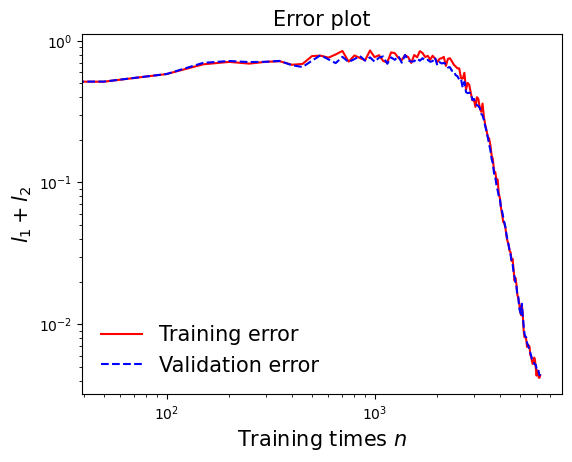

In [14]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

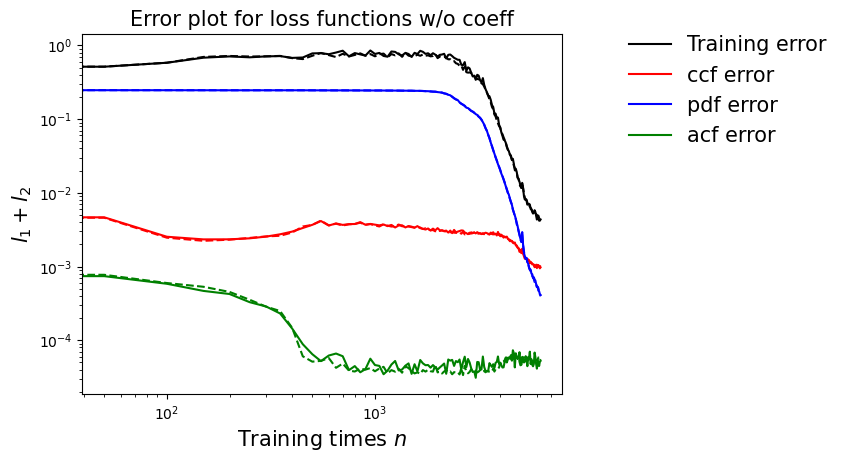

In [15]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [16]:
def test1(Traj, T, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

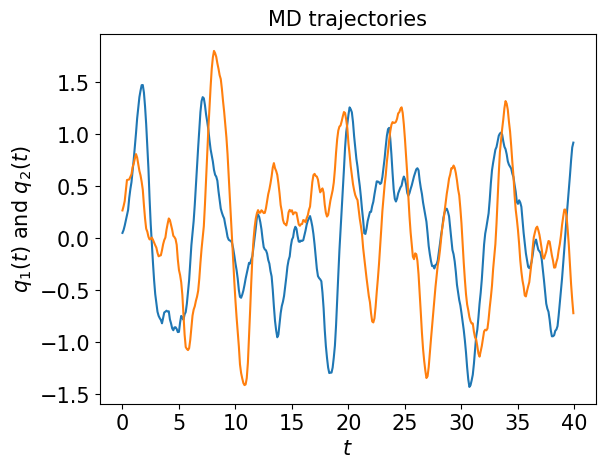

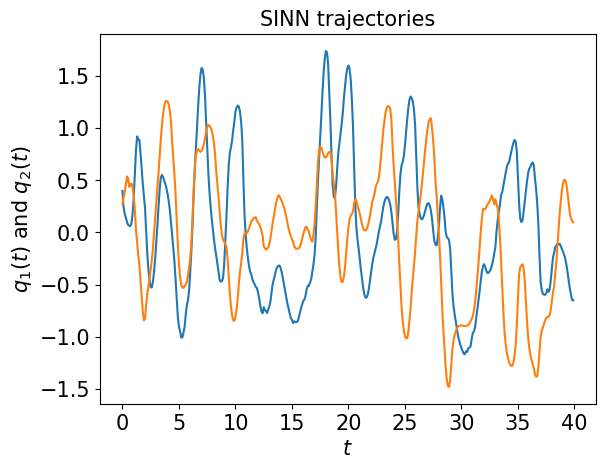

In [17]:
test1(Traj, T, net)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [18]:
def test2(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p=ccf_p.detach().cpu().numpy()
    corr_t=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1$',fontsize=15)    
    plt.plot(T, corr_t[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2$',fontsize=15)          
    plt.plot(T, corr_t[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t[...,1:3],'r')        # correlation function of the target 
    plt.plot(T, corr_p[...,1:3], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])

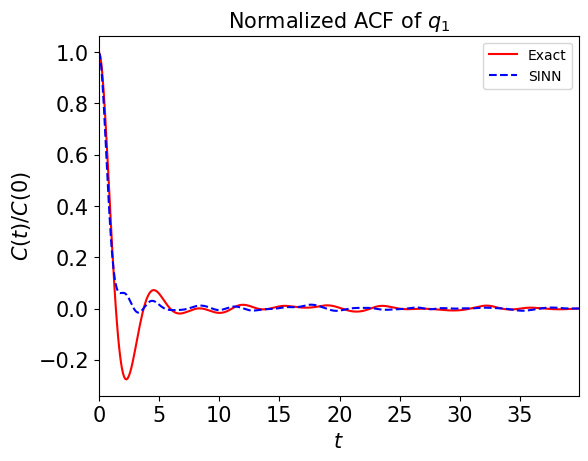

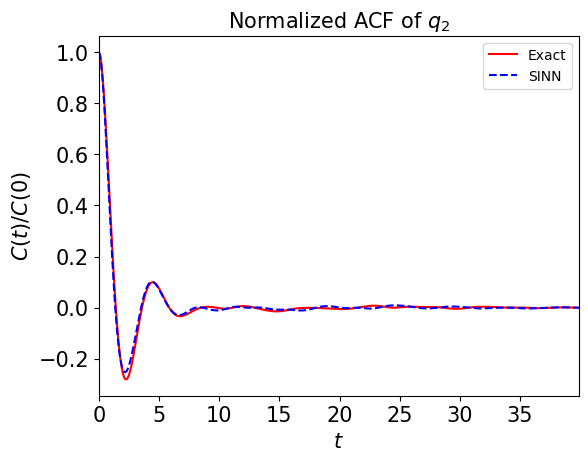

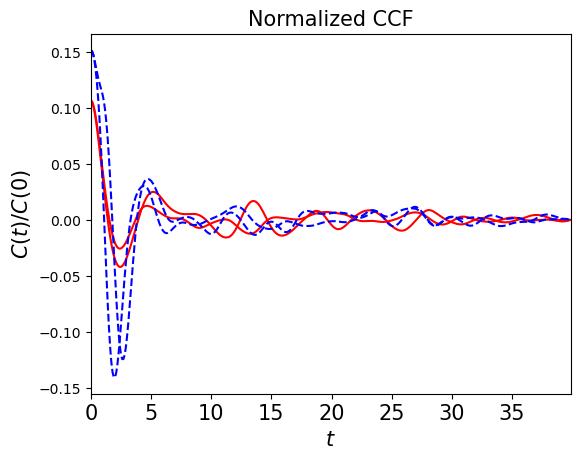

In [19]:
test2(target, net)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [20]:
def test3(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

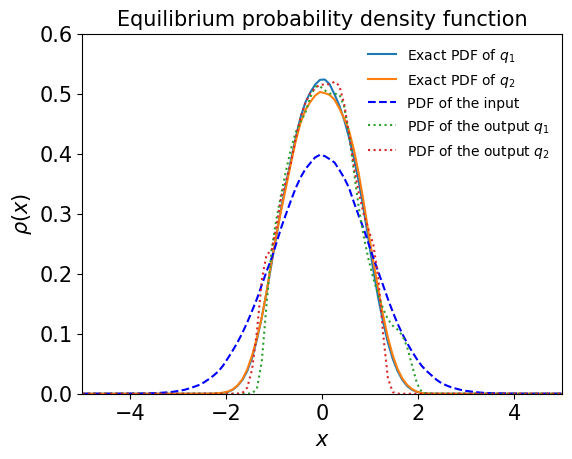

In [21]:
test3(target, net)

## Test 4: Comparing the higher-order ACF

In [22]:
def test4(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    
    
    
    
    
    


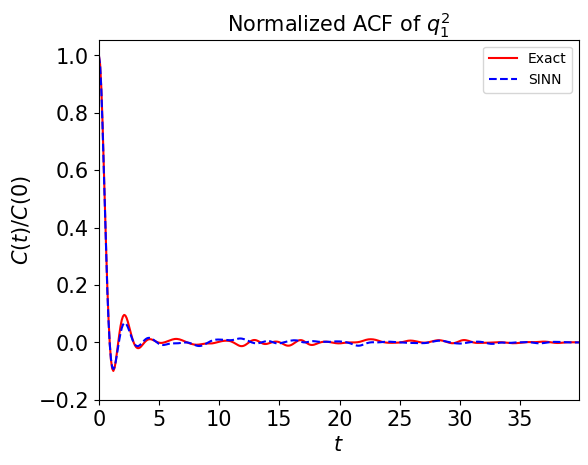

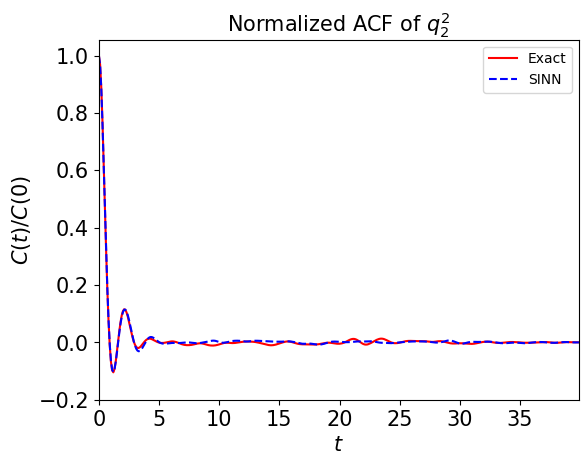

In [23]:
test4(target, net)

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [24]:
def test5(q1_store, q2_store, net):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= net(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

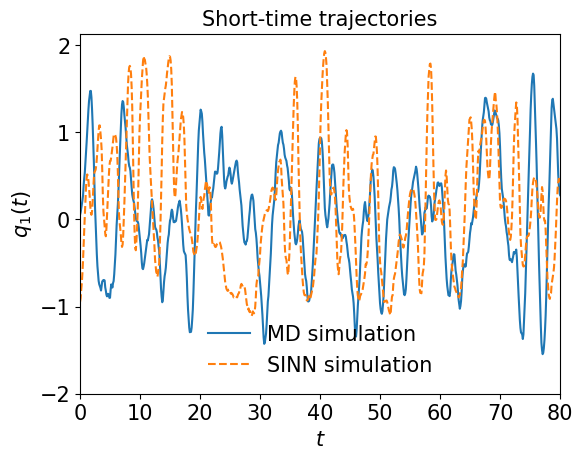

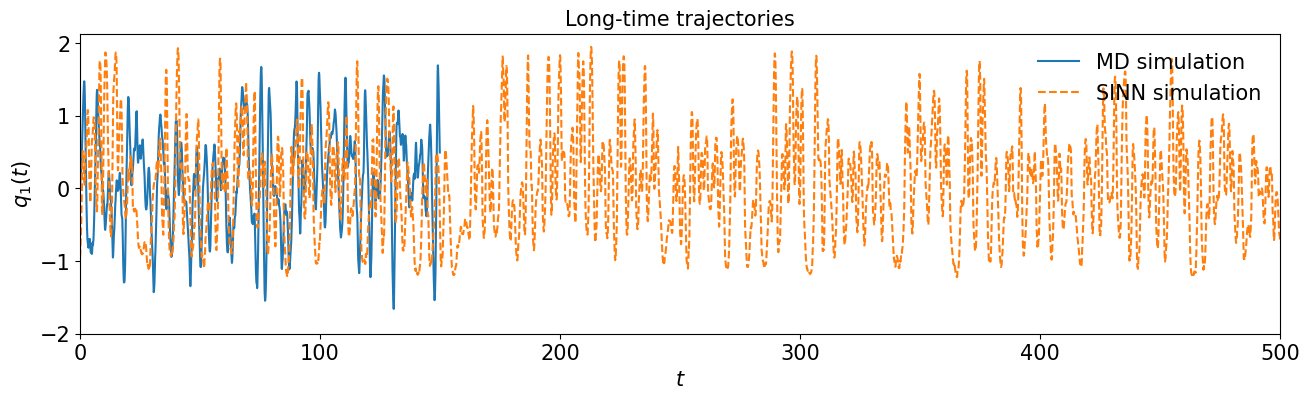

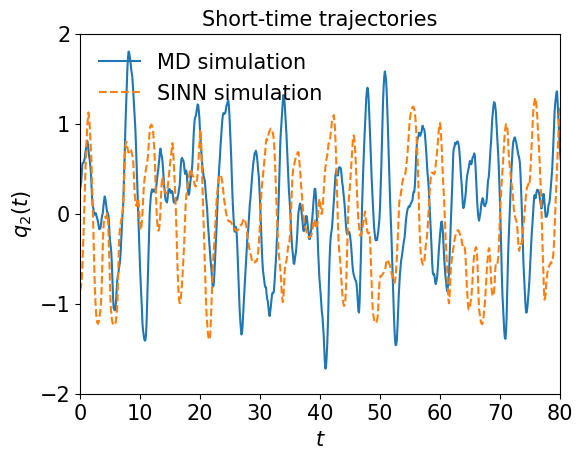

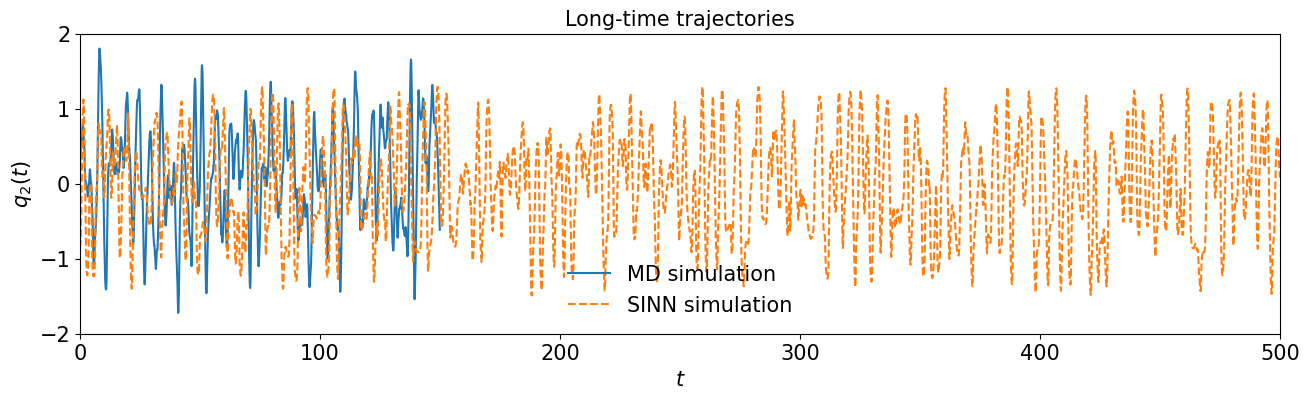

In [25]:
test5(q1_store, q2_store, net)

In [26]:
print(step)

6250


In [27]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.0005 and pdf<=0.0005 and acf_sec_moment<=0.0005:
            break

if ccf > 0.0005 or pdf >0.0005 or acf_sec_moment>0.0005:
    print ('Training failed')

print('Training finished')
print(step)

[6250]-th step loss: 0.0046, 0.0043, ccf: 0.00100, pdf: 0.00040, acf: 0.00006
[6300]-th step loss: 0.0048, 0.0050, ccf: 0.00097, pdf: 0.00050, acf: 0.00007
[6350]-th step loss: 0.0037, 0.0040, ccf: 0.00095, pdf: 0.00036, acf: 0.00006
[6400]-th step loss: 0.0038, 0.0039, ccf: 0.00094, pdf: 0.00033, acf: 0.00006
[6450]-th step loss: 0.0039, 0.0038, ccf: 0.00094, pdf: 0.00031, acf: 0.00005
[6500]-th step loss: 0.0039, 0.0039, ccf: 0.00093, pdf: 0.00029, acf: 0.00006
[6550]-th step loss: 0.0034, 0.0036, ccf: 0.00092, pdf: 0.00026, acf: 0.00005
[6600]-th step loss: 0.0038, 0.0036, ccf: 0.00091, pdf: 0.00024, acf: 0.00005
[6650]-th step loss: 0.0036, 0.0036, ccf: 0.00092, pdf: 0.00023, acf: 0.00005
[6700]-th step loss: 0.0035, 0.0035, ccf: 0.00090, pdf: 0.00021, acf: 0.00005
[6750]-th step loss: 0.0035, 0.0033, ccf: 0.00088, pdf: 0.00020, acf: 0.00005
[6800]-th step loss: 0.0035, 0.0035, ccf: 0.00087, pdf: 0.00020, acf: 0.00006
[6850]-th step loss: 0.0032, 0.0030, ccf: 0.00085, pdf: 0.00016,

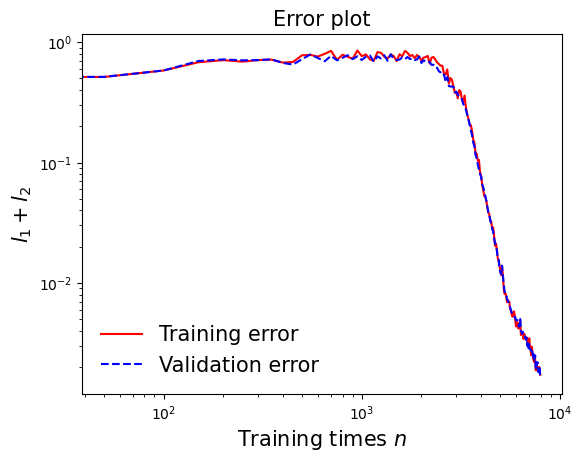

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

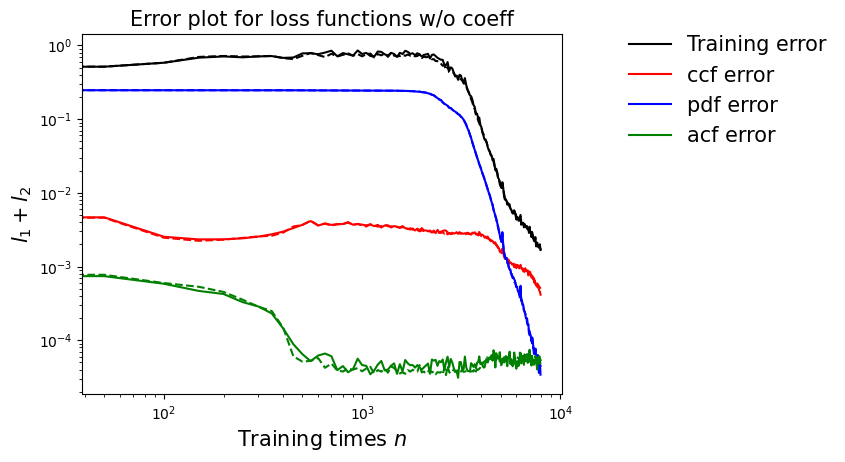

In [29]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

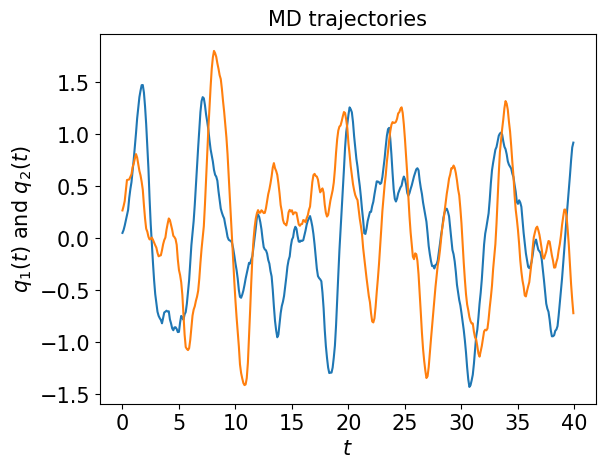

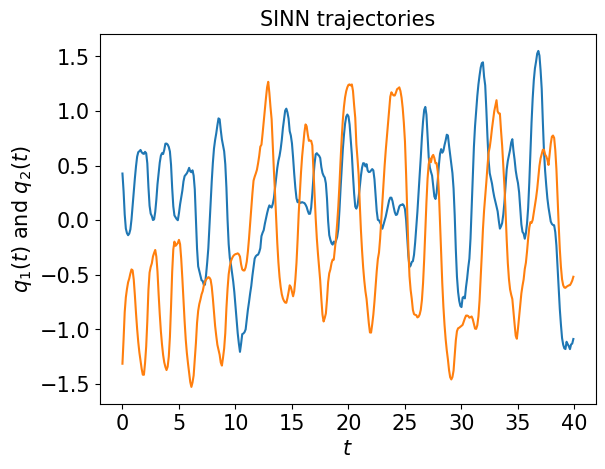

In [30]:
test1(Traj, T, net)

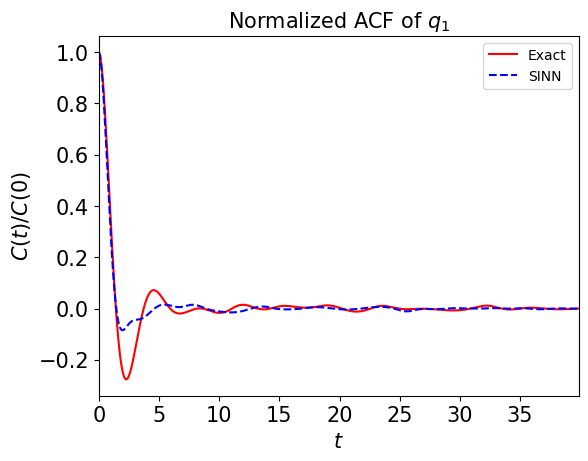

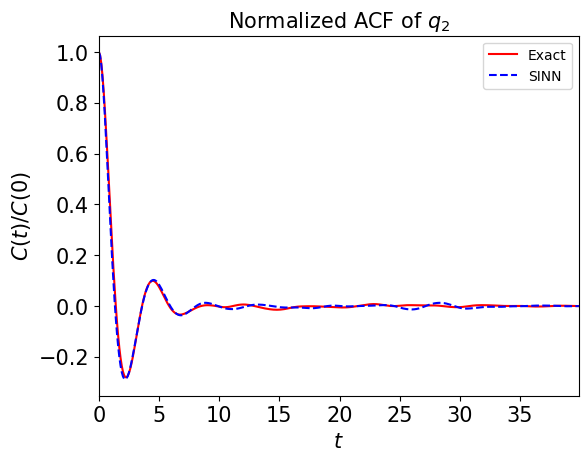

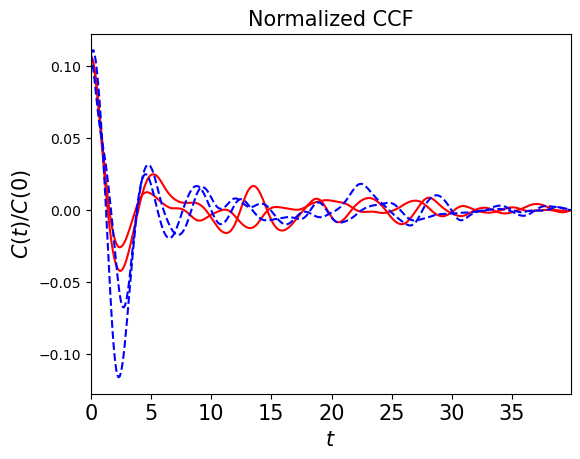

In [31]:
test2(target, net)

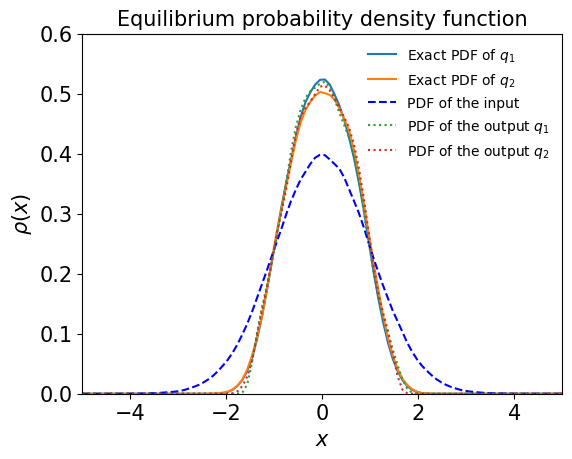

In [32]:
test3(target, net)

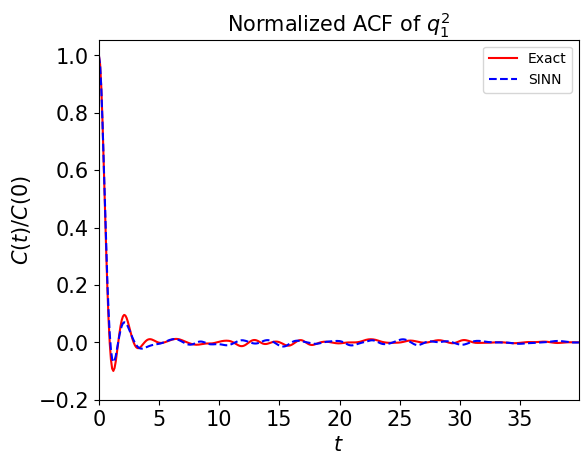

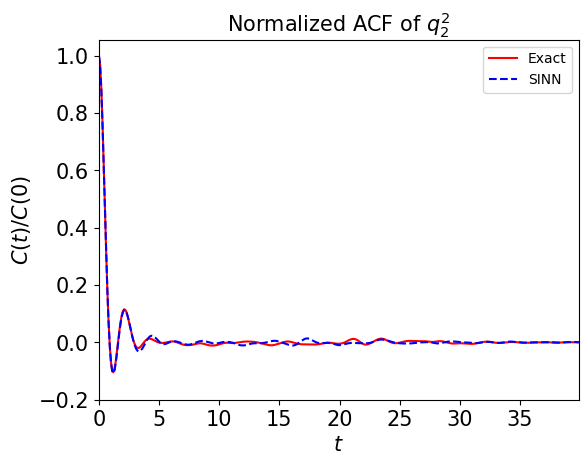

In [33]:
test4(target, net)

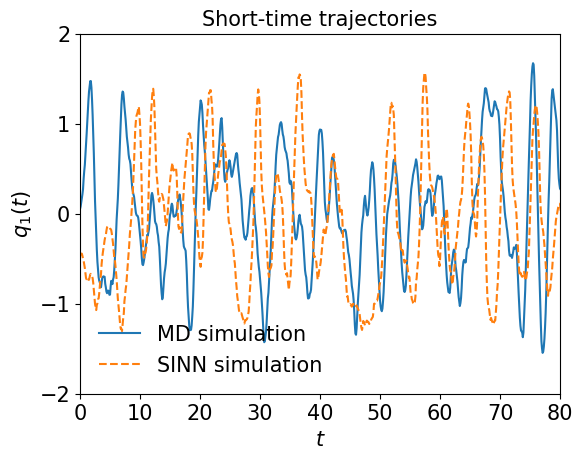

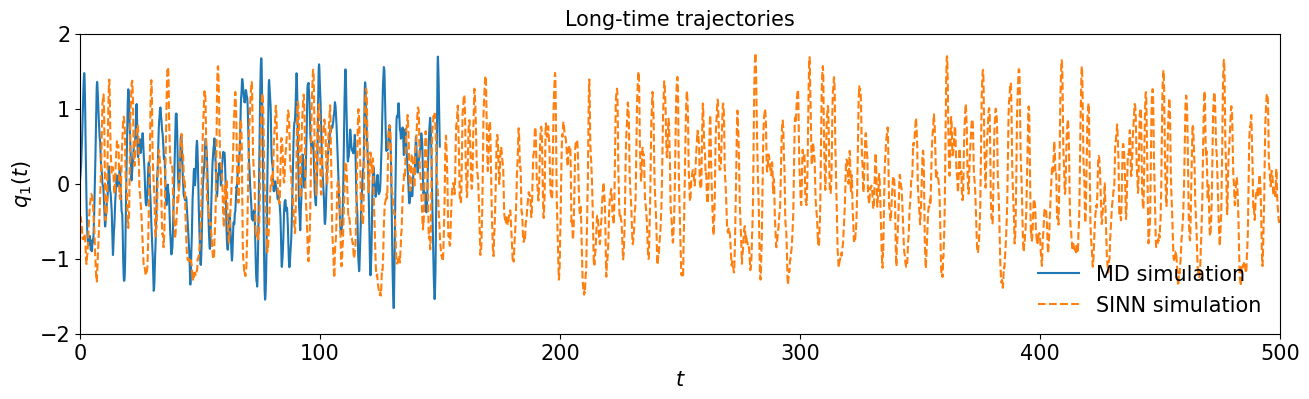

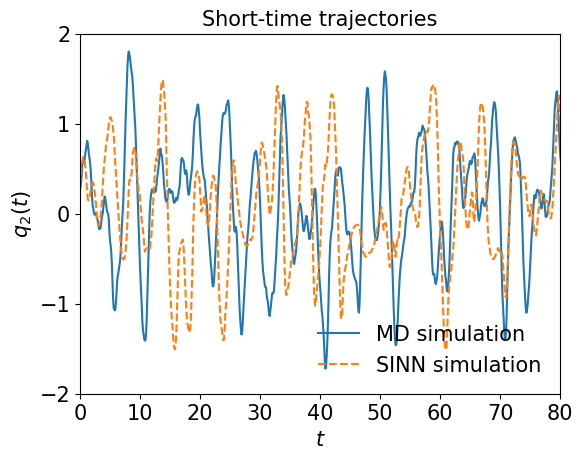

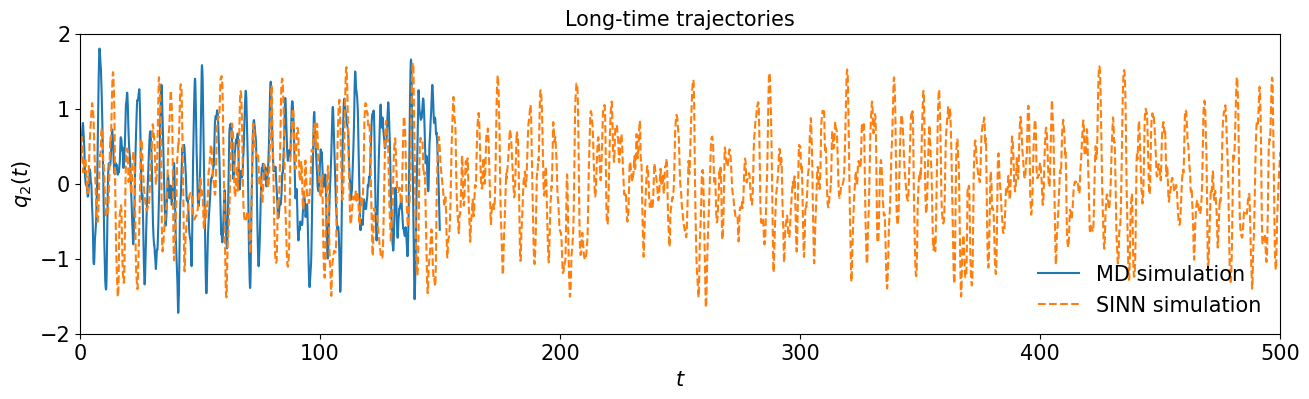

In [34]:
test5(q1_store, q2_store, net)

In [35]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.00025 and pdf<=0.00025 and acf_sec_moment<=0.00025:
            break

if ccf > 0.00025 or pdf >0.00025 or acf_sec_moment>0.00025:
    print ('Training failed')

print('Training finished')
print(step)

[7950]-th step loss: 0.0017, 0.0020, ccf: 0.00050, pdf: 0.00004, acf: 0.00006
[8000]-th step loss: 0.0016, 0.0018, ccf: 0.00048, pdf: 0.00004, acf: 0.00005
[8050]-th step loss: 0.0014, 0.0015, ccf: 0.00045, pdf: 0.00003, acf: 0.00005
[8100]-th step loss: 0.0018, 0.0015, ccf: 0.00044, pdf: 0.00003, acf: 0.00005
[8150]-th step loss: 0.0019, 0.0019, ccf: 0.00043, pdf: 0.00005, acf: 0.00005
[8200]-th step loss: 0.0016, 0.0013, ccf: 0.00041, pdf: 0.00002, acf: 0.00005
[8250]-th step loss: 0.0016, 0.0014, ccf: 0.00040, pdf: 0.00002, acf: 0.00005
[8300]-th step loss: 0.0017, 0.0014, ccf: 0.00039, pdf: 0.00002, acf: 0.00005
[8350]-th step loss: 0.0014, 0.0018, ccf: 0.00039, pdf: 0.00004, acf: 0.00006
[8400]-th step loss: 0.0012, 0.0012, ccf: 0.00036, pdf: 0.00003, acf: 0.00005
[8450]-th step loss: 0.0012, 0.0014, ccf: 0.00034, pdf: 0.00003, acf: 0.00005
[8500]-th step loss: 0.0011, 0.0012, ccf: 0.00033, pdf: 0.00003, acf: 0.00005
[8550]-th step loss: 0.0011, 0.0010, ccf: 0.00033, pdf: 0.00002,

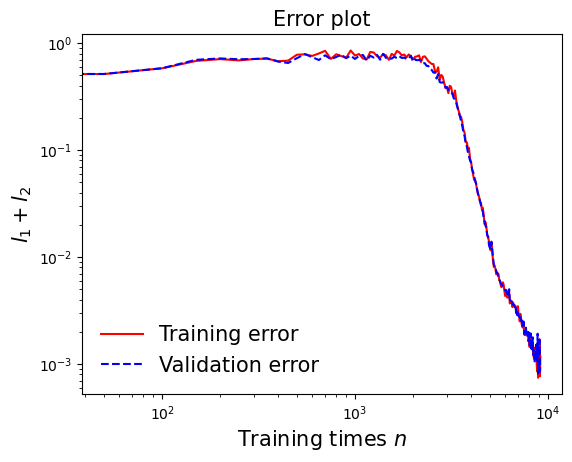

In [36]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

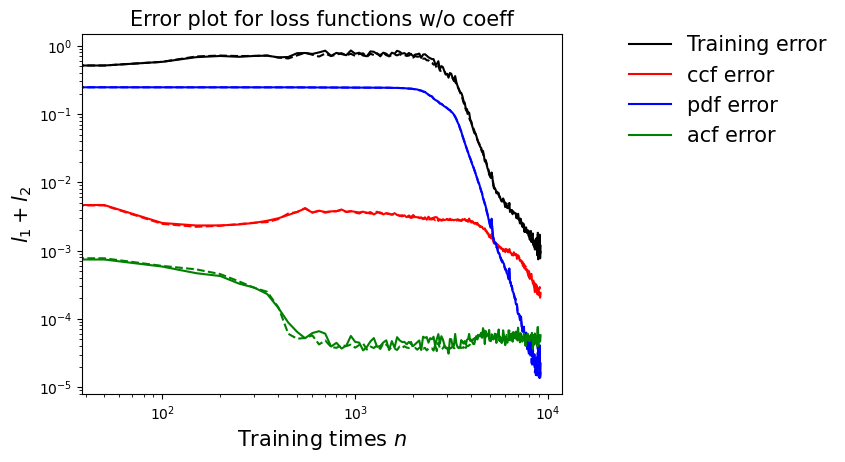

In [37]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

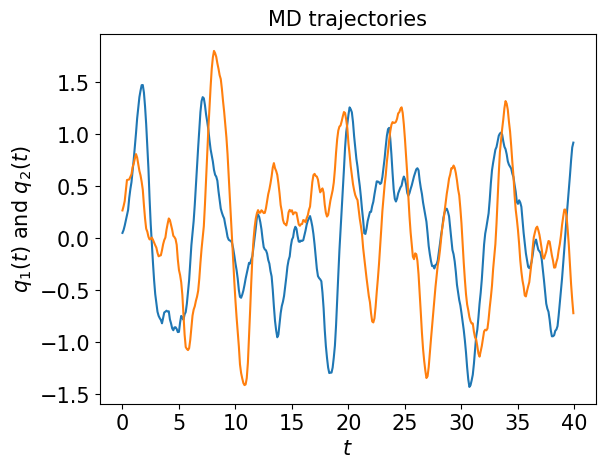

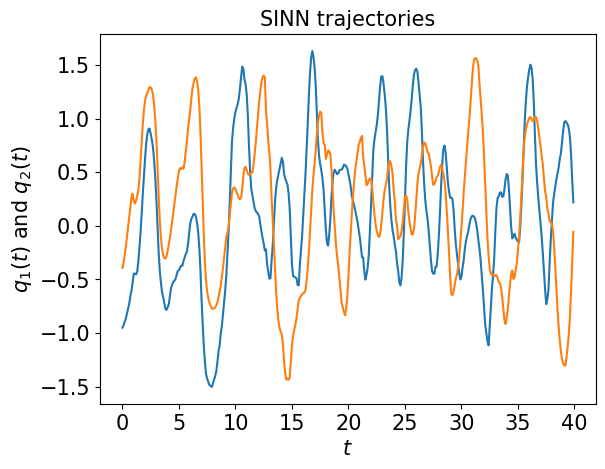

In [38]:
test1(Traj, T, net)

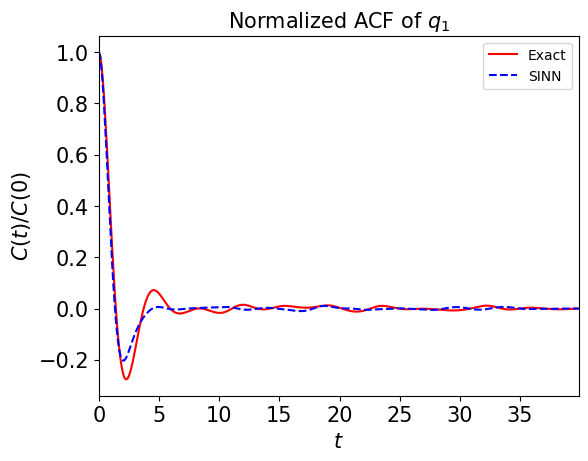

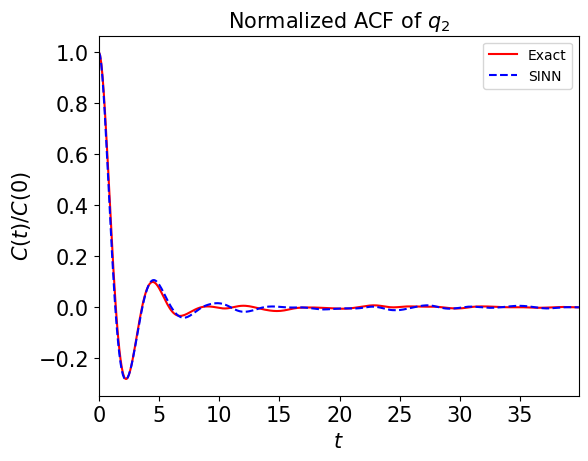

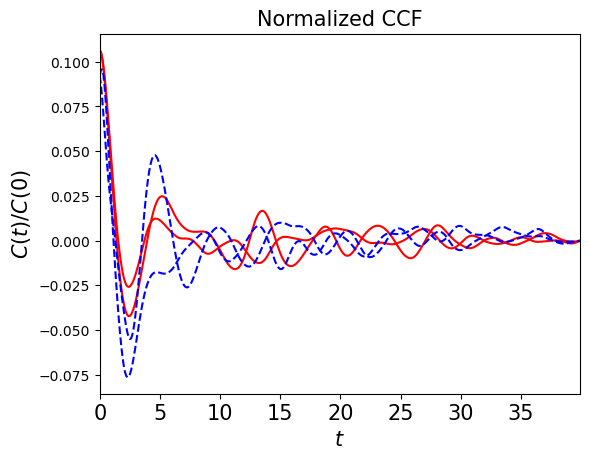

In [39]:
test2(target, net)

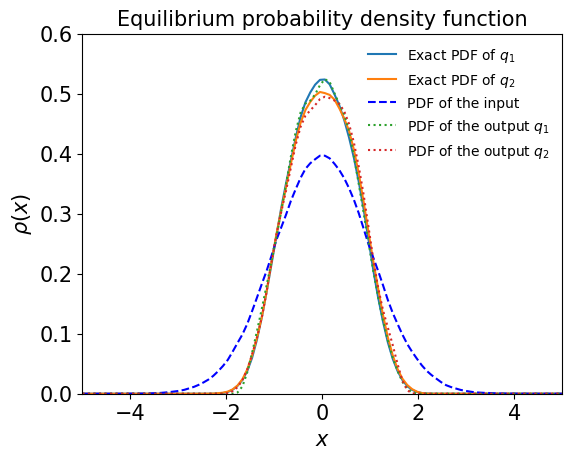

In [40]:
test3(target, net)

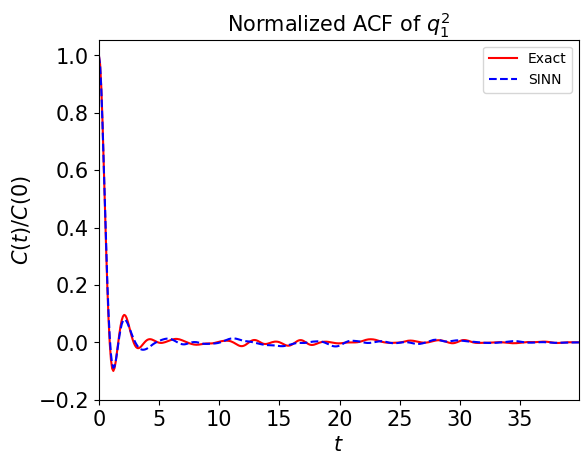

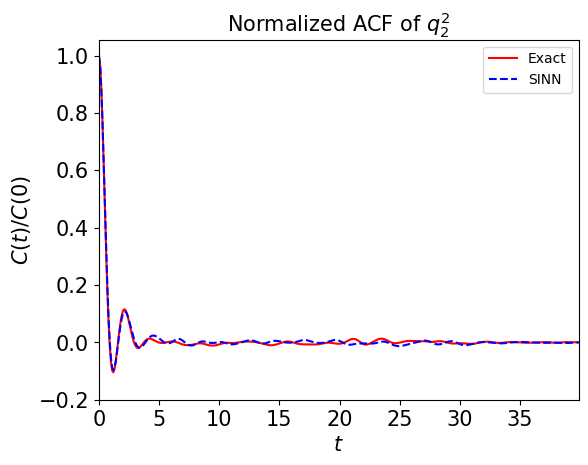

In [41]:
test4(target, net)

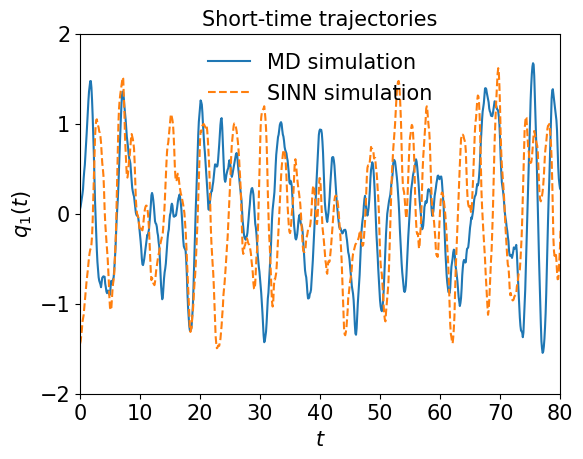

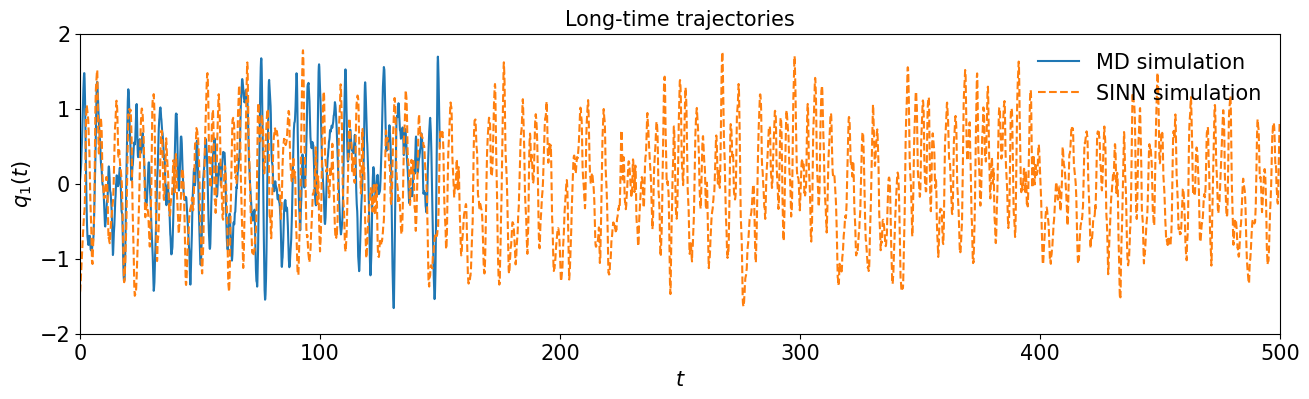

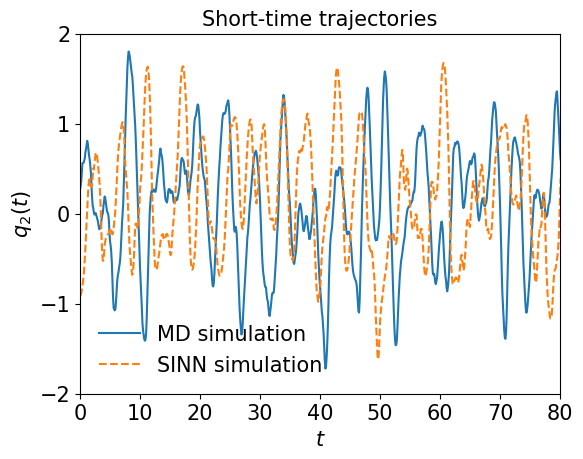

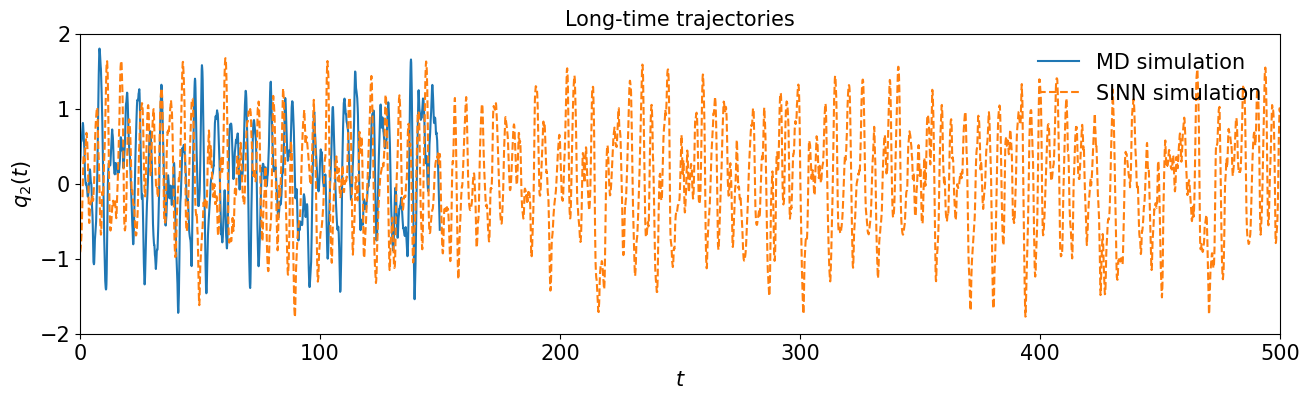

In [42]:
test5(q1_store, q2_store, net)

In [43]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.000125 and pdf<=0.000125 and acf_sec_moment<=0.000125:
            break

if ccf > 0.000125 or pdf >0.000125 or acf_sec_moment>0.000125:
    print ('Training failed')

print('Training finished')
print(step)

[9150]-th step loss: 0.0011, 0.0010, ccf: 0.00024, pdf: 0.00002, acf: 0.00005
[9200]-th step loss: 0.0009, 0.0011, ccf: 0.00024, pdf: 0.00003, acf: 0.00005
[9250]-th step loss: 0.0008, 0.0010, ccf: 0.00025, pdf: 0.00003, acf: 0.00005
[9300]-th step loss: 0.0009, 0.0010, ccf: 0.00023, pdf: 0.00004, acf: 0.00005
[9350]-th step loss: 0.0017, 0.0017, ccf: 0.00036, pdf: 0.00006, acf: 0.00010
[9400]-th step loss: 0.0009, 0.0008, ccf: 0.00024, pdf: 0.00002, acf: 0.00005
[9450]-th step loss: 0.0011, 0.0010, ccf: 0.00025, pdf: 0.00003, acf: 0.00004
[9500]-th step loss: 0.0008, 0.0008, ccf: 0.00024, pdf: 0.00001, acf: 0.00004
[9550]-th step loss: 0.0014, 0.0012, ccf: 0.00033, pdf: 0.00002, acf: 0.00005
[9600]-th step loss: 0.0010, 0.0011, ccf: 0.00027, pdf: 0.00002, acf: 0.00005
[9650]-th step loss: 0.0031, 0.0029, ccf: 0.00051, pdf: 0.00008, acf: 0.00010
[9700]-th step loss: 0.0011, 0.0009, ccf: 0.00033, pdf: 0.00002, acf: 0.00004
[9750]-th step loss: 0.0011, 0.0010, ccf: 0.00028, pdf: 0.00001,

[14350]-th step loss: 0.0007, 0.0008, ccf: 0.00020, pdf: 0.00002, acf: 0.00007
[14400]-th step loss: 0.0008, 0.0008, ccf: 0.00019, pdf: 0.00002, acf: 0.00007
[14450]-th step loss: 0.0007, 0.0008, ccf: 0.00018, pdf: 0.00002, acf: 0.00007
[14500]-th step loss: 0.0010, 0.0007, ccf: 0.00019, pdf: 0.00001, acf: 0.00006
[14550]-th step loss: 0.0009, 0.0009, ccf: 0.00017, pdf: 0.00001, acf: 0.00006
[14600]-th step loss: 0.0007, 0.0007, ccf: 0.00017, pdf: 0.00001, acf: 0.00006
[14650]-th step loss: 0.0008, 0.0008, ccf: 0.00016, pdf: 0.00002, acf: 0.00006
[14700]-th step loss: 0.0008, 0.0006, ccf: 0.00016, pdf: 0.00001, acf: 0.00006
[14750]-th step loss: 0.0008, 0.0009, ccf: 0.00016, pdf: 0.00003, acf: 0.00006
[14800]-th step loss: 0.0020, 0.0025, ccf: 0.00027, pdf: 0.00018, acf: 0.00008
[14850]-th step loss: 0.0007, 0.0007, ccf: 0.00016, pdf: 0.00001, acf: 0.00005
[14900]-th step loss: 0.0006, 0.0008, ccf: 0.00016, pdf: 0.00002, acf: 0.00006
[14950]-th step loss: 0.0005, 0.0007, ccf: 0.00016, 

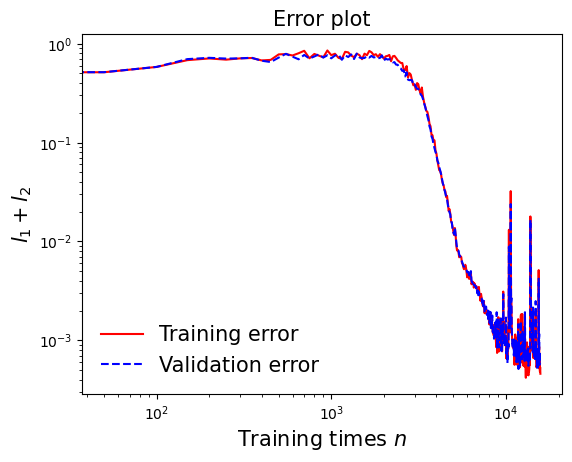

In [44]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

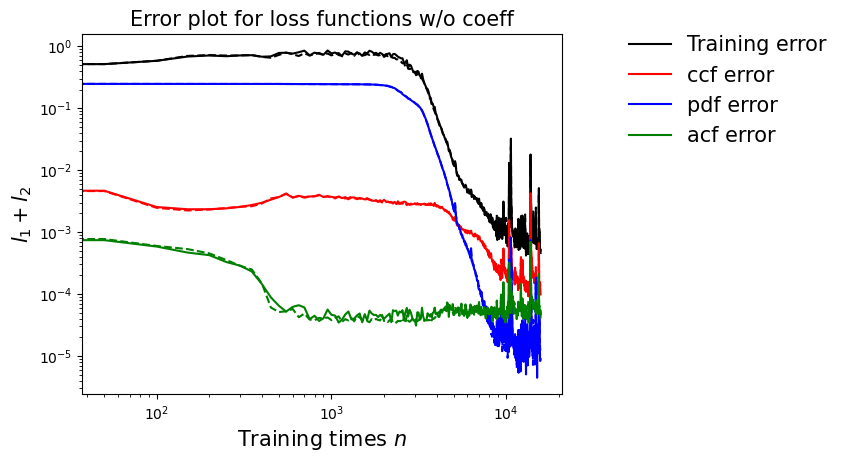

In [45]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

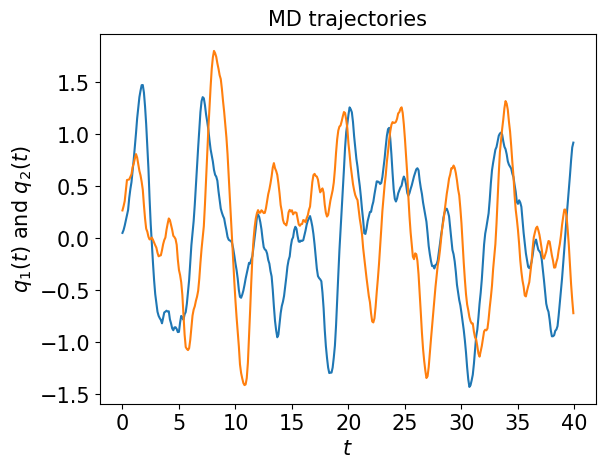

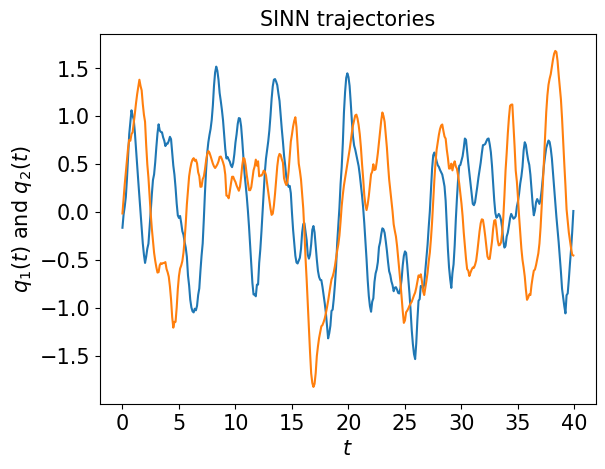

In [46]:
test1(Traj, T, net)

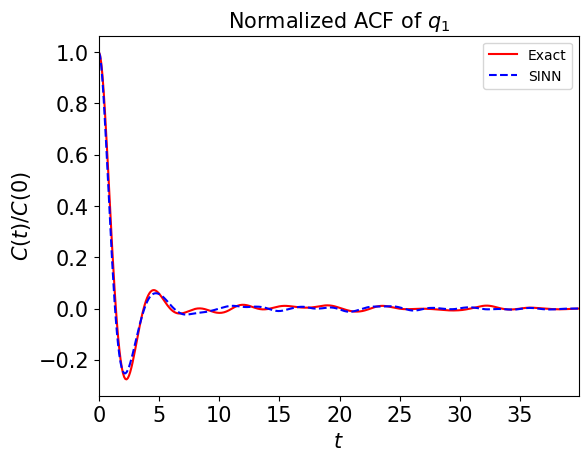

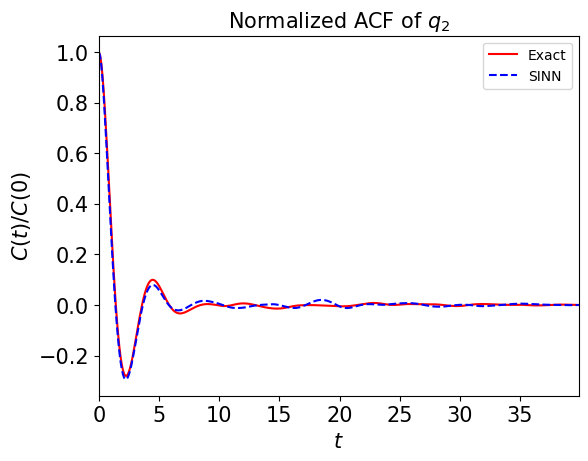

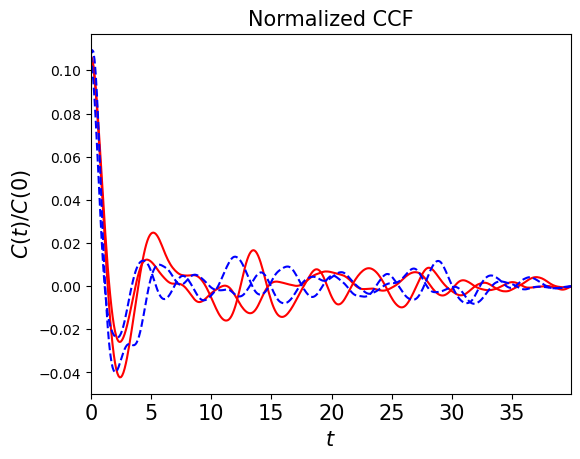

In [47]:
test2(target, net)

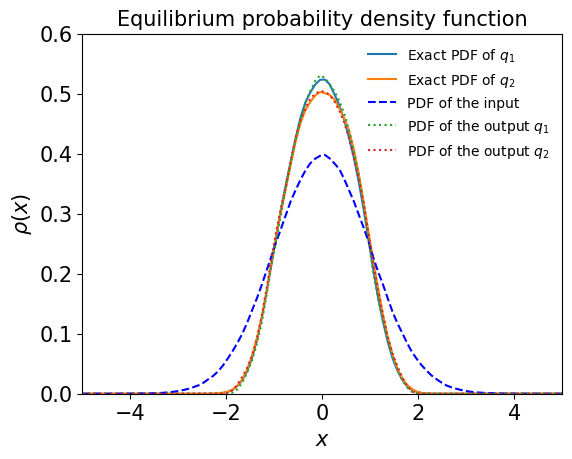

In [48]:
test3(target, net)

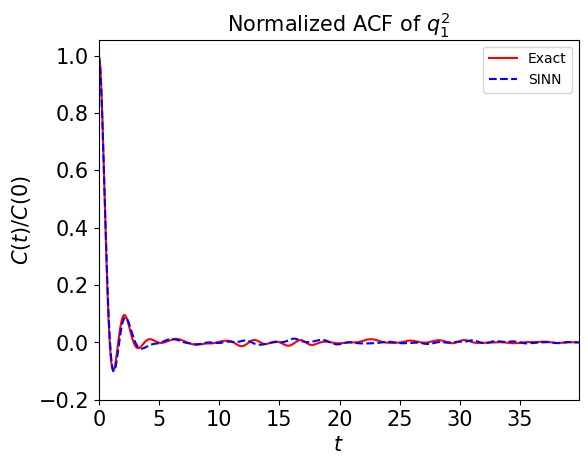

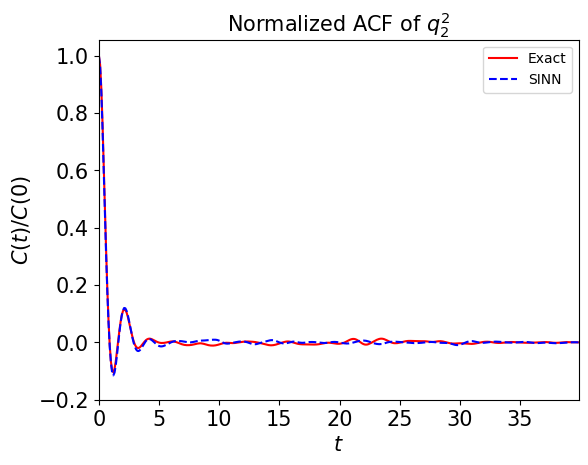

In [49]:
test4(target, net)

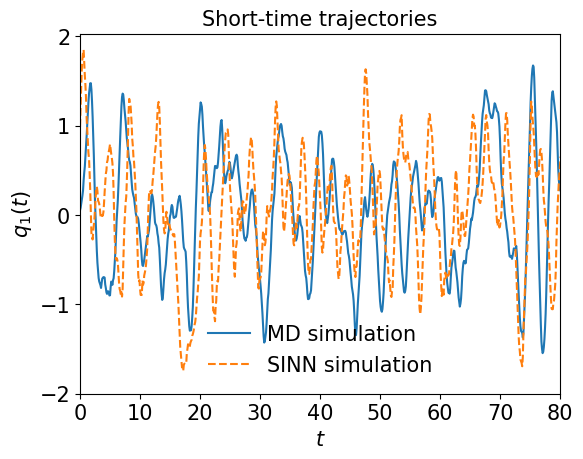

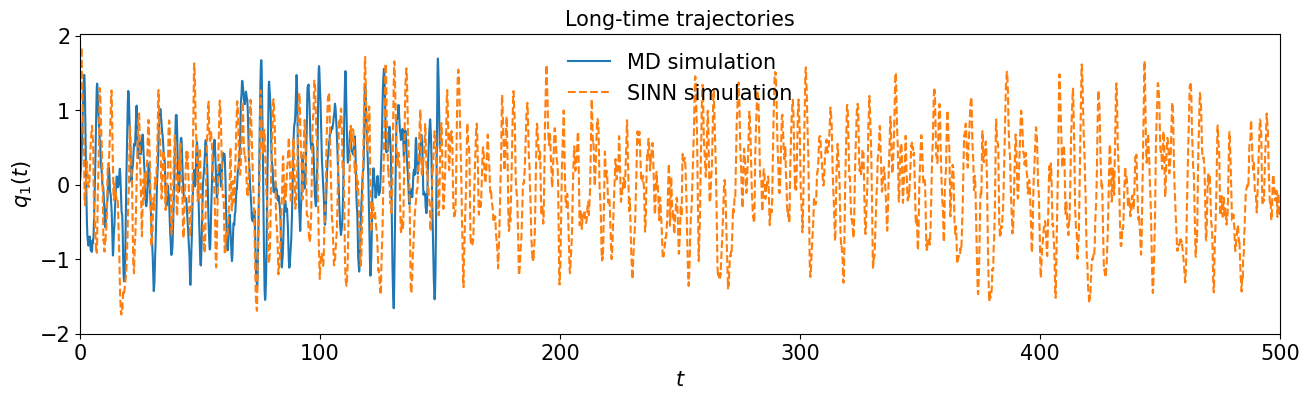

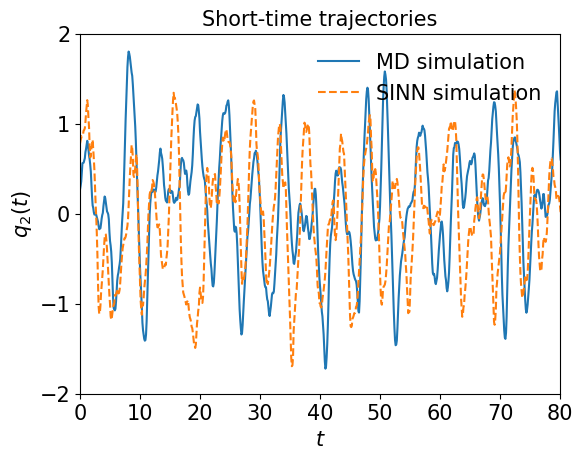

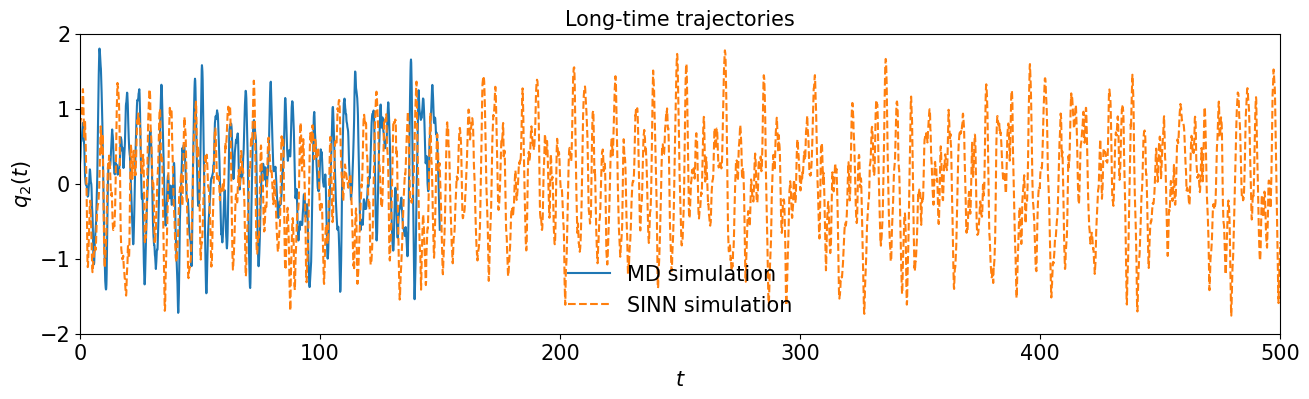

In [50]:
test5(q1_store, q2_store, net)

In [51]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.00010 and pdf<=0.00005 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.00005 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')
print(step)

[15750]-th step loss: 0.0007, 0.0006, ccf: 0.00012, pdf: 0.00001, acf: 0.00005
[15800]-th step loss: 0.0023, 0.0019, ccf: 0.00035, pdf: 0.00006, acf: 0.00010
[15850]-th step loss: 0.0005, 0.0006, ccf: 0.00013, pdf: 0.00002, acf: 0.00005
[15900]-th step loss: 0.0005, 0.0005, ccf: 0.00013, pdf: 0.00001, acf: 0.00004
[15950]-th step loss: 0.0008, 0.0009, ccf: 0.00017, pdf: 0.00003, acf: 0.00006
[16000]-th step loss: 0.0004, 0.0005, ccf: 0.00013, pdf: 0.00001, acf: 0.00005
[16050]-th step loss: 0.0006, 0.0008, ccf: 0.00015, pdf: 0.00002, acf: 0.00006
[16100]-th step loss: 0.0005, 0.0005, ccf: 0.00011, pdf: 0.00001, acf: 0.00005
[16150]-th step loss: 0.0005, 0.0006, ccf: 0.00013, pdf: 0.00002, acf: 0.00006
[16200]-th step loss: 0.0005, 0.0005, ccf: 0.00010, pdf: 0.00001, acf: 0.00004
[16250]-th step loss: 0.0004, 0.0005, ccf: 0.00011, pdf: 0.00001, acf: 0.00005
[16300]-th step loss: 0.0006, 0.0005, ccf: 0.00015, pdf: 0.00001, acf: 0.00005
[16350]-th step loss: 0.0207, 0.0494, ccf: 0.00768, 

# 2. 2 inputs

In [47]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [48]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

In [49]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [50]:
### coefficients of loss functions
c1 = 1               # coefficient of CCF
c2 = 1              # coefficient of PDF
c3 = 1               # coefficient of ACF of second moment

In [51]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.0001 and pdf<=0.00001 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.00001 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 0.2591, 0.2583, ccf: 0.00370, pdf: 0.25331, acf: 0.00127
[50]-th step loss: 0.5048, 0.5100, ccf: 0.00203, pdf: 0.25020, acf: 0.00056
[100]-th step loss: 0.7095, 0.7093, ccf: 0.00213, pdf: 0.24872, acf: 0.00042
[150]-th step loss: 0.6676, 0.6577, ccf: 0.00237, pdf: 0.24413, acf: 0.00022
[200]-th step loss: 0.5926, 0.5793, ccf: 0.00285, pdf: 0.22249, acf: 0.00005
[250]-th step loss: 0.6567, 0.5989, ccf: 0.00304, pdf: 0.18957, acf: 0.00004
[300]-th step loss: 0.6261, 0.5509, ccf: 0.00328, pdf: 0.16814, acf: 0.00003
[350]-th step loss: 0.4924, 0.4895, ccf: 0.00305, pdf: 0.14944, acf: 0.00004
[400]-th step loss: 0.4739, 0.4370, ccf: 0.00279, pdf: 0.13315, acf: 0.00004
[450]-th step loss: 0.3711, 0.4035, ccf: 0.00240, pdf: 0.11527, acf: 0.00005
[500]-th step loss: 0.3376, 0.3078, ccf: 0.00213, pdf: 0.09343, acf: 0.00004
[550]-th step loss: 0.2828, 0.2644, ccf: 0.00194, pdf: 0.07311, acf: 0.00005
[600]-th step loss: 0.1969, 0.2071, ccf: 0.00189, pdf: 0.05628, acf: 0.00005
[6

[5300]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00009, acf: 0.00010
[5350]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00009, acf: 0.00010
[5400]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00008, acf: 0.00010
[5450]-th step loss: 0.0009, 0.0008, ccf: 0.00009, pdf: 0.00009, acf: 0.00009
[5500]-th step loss: 0.0008, 0.0008, ccf: 0.00008, pdf: 0.00008, acf: 0.00010
[5550]-th step loss: 0.0009, 0.0007, ccf: 0.00007, pdf: 0.00007, acf: 0.00010
[5600]-th step loss: 0.0008, 0.0007, ccf: 0.00009, pdf: 0.00007, acf: 0.00008
[5650]-th step loss: 0.0008, 0.0007, ccf: 0.00007, pdf: 0.00006, acf: 0.00010
[5700]-th step loss: 0.0007, 0.0007, ccf: 0.00006, pdf: 0.00006, acf: 0.00010
[5750]-th step loss: 0.0008, 0.0007, ccf: 0.00006, pdf: 0.00006, acf: 0.00010
[5800]-th step loss: 0.0007, 0.0007, ccf: 0.00007, pdf: 0.00005, acf: 0.00010
[5850]-th step loss: 0.0007, 0.0006, ccf: 0.00006, pdf: 0.00005, acf: 0.00010
[5900]-th step loss: 0.0007, 0.0007, ccf: 0.00006, pdf: 0.00005,

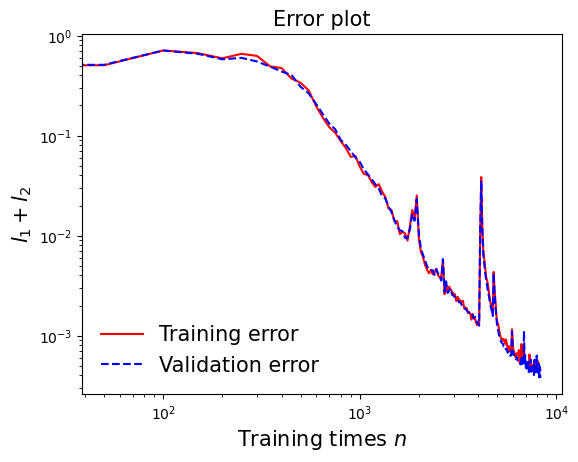

In [52]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

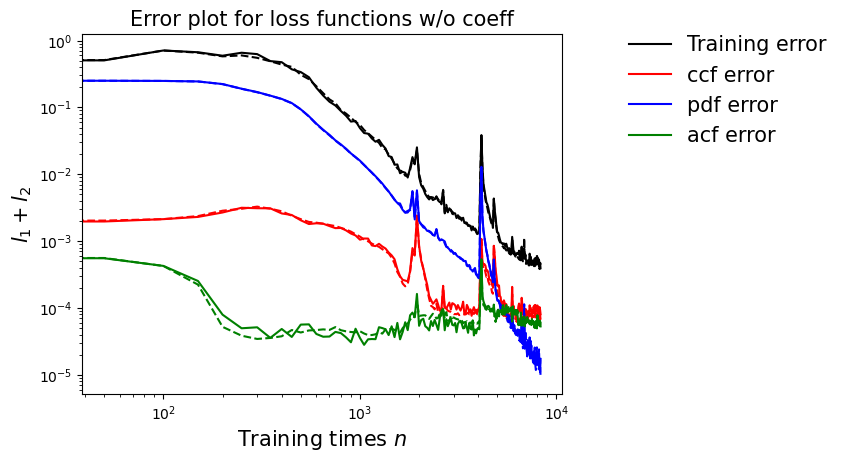

In [53]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

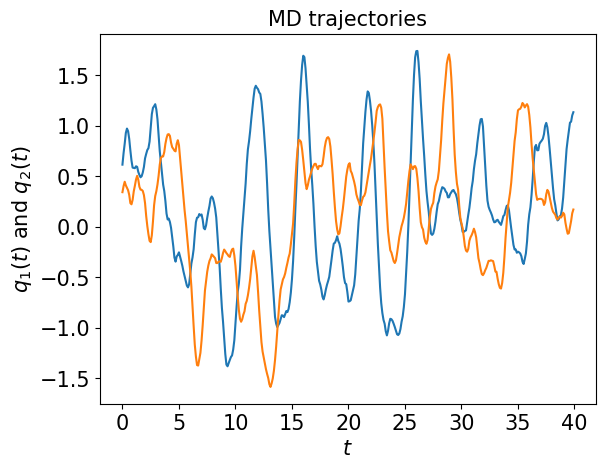

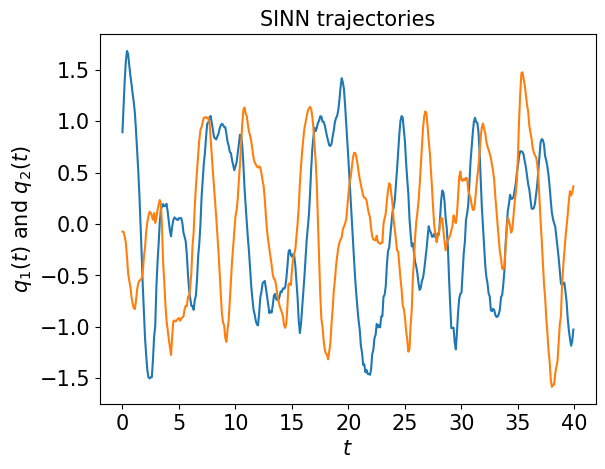

In [54]:
test1(Traj, T, net)

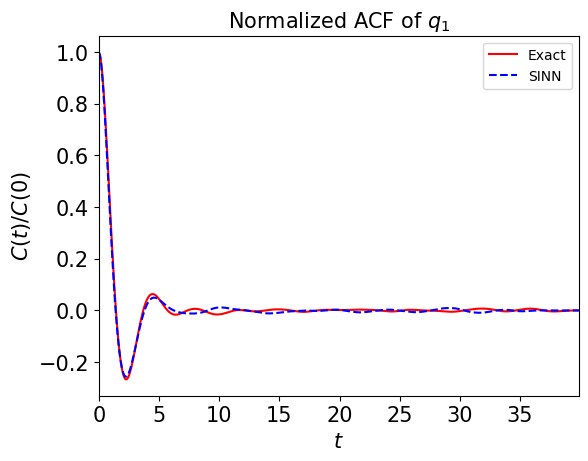

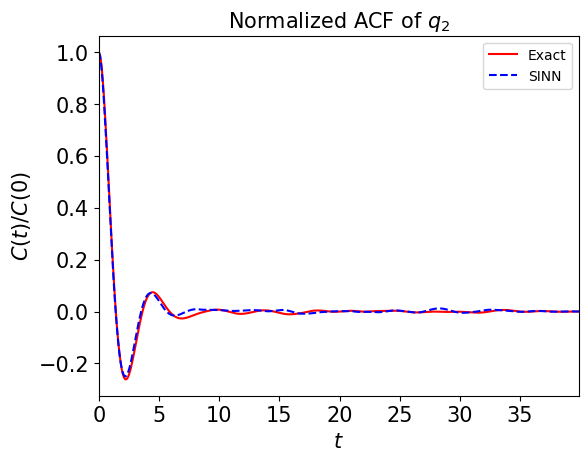

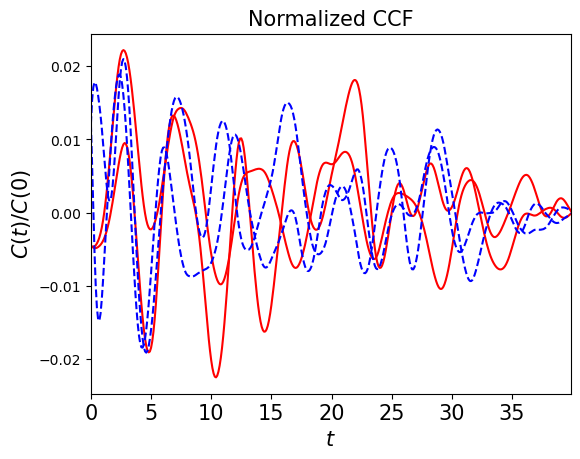

In [55]:
test2(target, net)

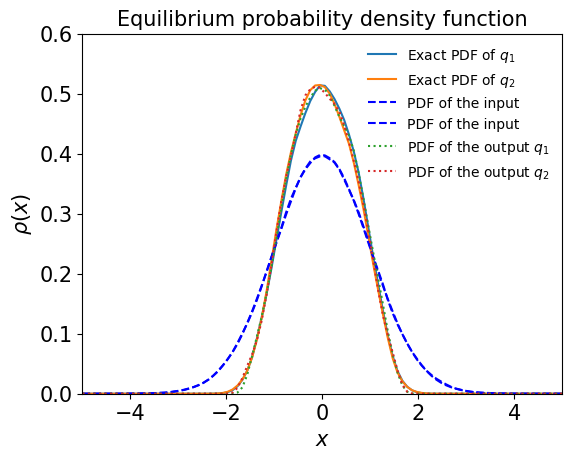

In [56]:
test3(target, net)

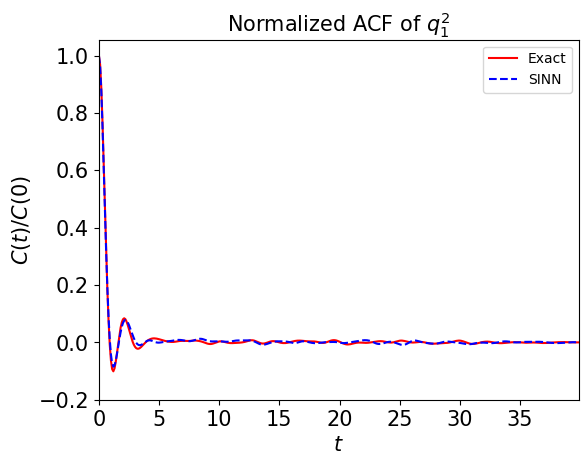

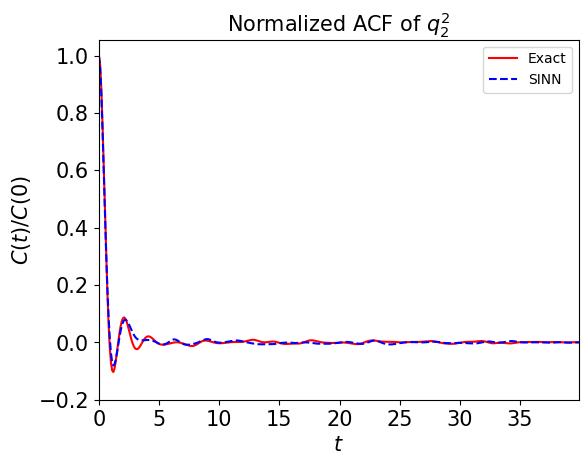

In [57]:
test4(target, net)

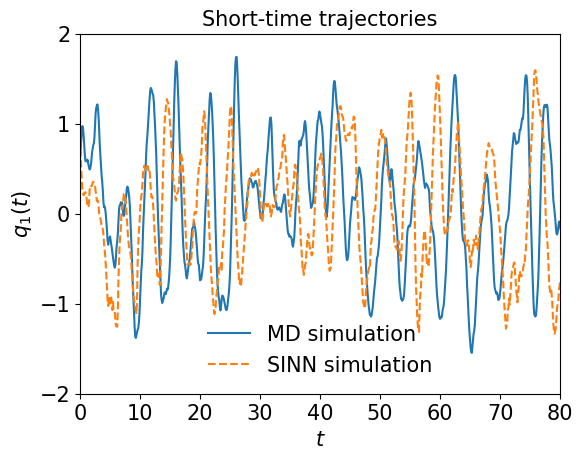

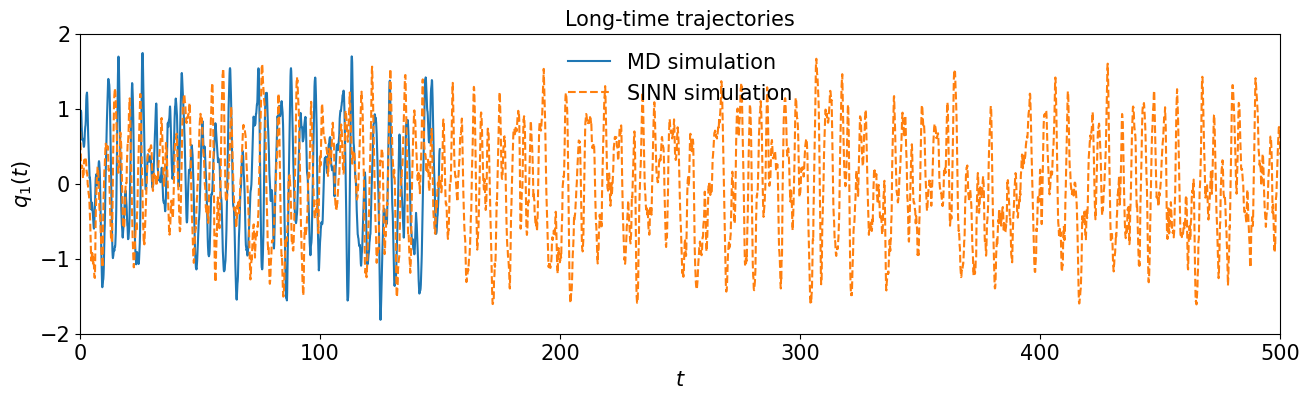

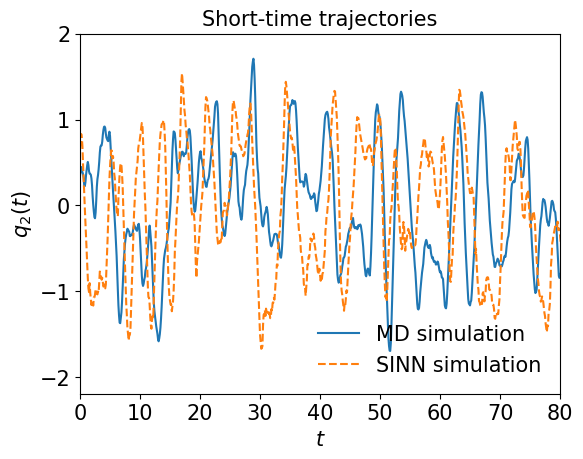

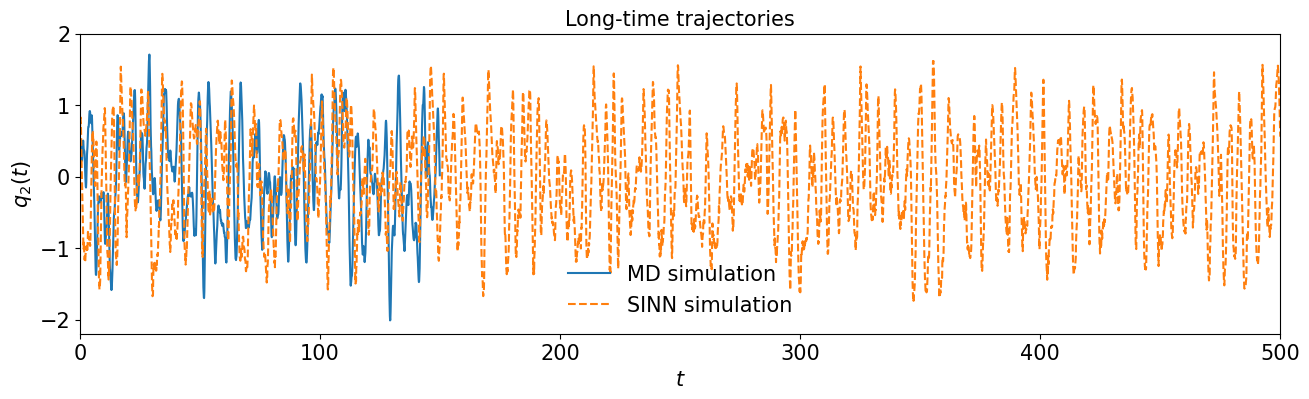

In [58]:
test5(q1_store, q2_store, net)